In [1]:
import numpy as np
import moviepy.editor as mpe
import matplotlib.pyplot as plt
from tqdm import trange
from numba import prange, njit
from skimage import io
from time import time

In [2]:
from numpy.random import default_rng

In [3]:
rng = default_rng(69) #integers method low high size args

In [4]:
gaus1d = np.exp(-0.5*(np.arange(-2,3))**2)/np.sqrt(2*np.pi)

@njit
def gausblurfast(p):
    c = p.copy()
    first, second = c.shape[0],c.shape[1]
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,0] = np.average(p[i-2:i+3,j,0],weights=gaus1d)
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,1] = np.average(p[i-2:i+3,j,1],weights=gaus1d)
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,2] = np.average(p[i-2:i+3,j,2],weights=gaus1d)
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,0] = np.average(p[i,j-2:j+3,0],weights=gaus1d)
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,1] = np.average(p[i,j-2:j+3,1],weights=gaus1d)
    for i in prange(2, first-2):
        for j in range(2, second-2):
            c[i, j,2] = np.average(p[i,j-2:j+3,2],weights=gaus1d)
    return c

In [5]:
def makeglitch(p,up,down):
    c = p.copy()
    c[up:down,:]=p[up,:]
    return c

In [6]:
def distort(p, arg =1, seed = 69, width = 1):
    c = p.copy()
    rng = default_rng(seed)
    x,y,_ = c.shape
    counter = x//width
    sett = rng.standard_normal(counter)
    for i in range(counter):
        if sett[i] > 0:
            c[i*width:width*(i+1),arg:] = p[i*width:width*(i+1),:y - arg]
        else:
            c[i*width:width*(i+1),:y - arg] = p[i*width:width*(i+1),arg:]
    return c

def distortrand(p,wmax=20, argmax = 4, seed = 69):
    c = p.copy()
    rng = default_rng(seed)
    x,y,_ = c.shape
    sett = rng.standard_normal(x)
    i = 0
    while i < x:
        width = rng.integers(high=wmax, low=10, size=1)[0]
        arg = rng.integers(high=argmax, low=1, size=1)[0]
        if sett[i] > 0:
            c[i:width+i+1,arg:] = p[i:width+i+1,:y - arg]
        else:
            c[i:width+i+1,:y - arg] = p[i:width+i+1,arg:]
        i +=width
    return c

def distortranddifcol(p,wmax=20, argmax = 4, seed = 69):
    c = p.copy()
    rng = default_rng(seed)
    x,y,_ = c.shape
    sett = rng.standard_normal(x)
    i = 0
    while i < x:
        width = rng.integers(high=wmax, low=10, size=1)[0]
        arg = rng.integers(high=argmax, low=1, size=1)[0]
        if sett[i] > 0:
            c[i:width+i+1,arg:,0] = p[i:width+i+1,:y - arg,0]
            c[i:width+i+1,:y - arg,1] = p[i:width+i+1,arg:,1]#
        else:
            c[i:width+i+1,:y - arg,0] = p[i:width+i+1,arg:,0]
            c[i:width+i+1,arg:,0] = p[i:width+i+1,:y - arg,1]#
        i +=width
    return c


def distortrandred(p,wmax=20, argmax = 4, seed = 69):
    c = p.copy()
    rng = default_rng(seed)
    x,y,_ = c.shape
    sett = rng.standard_normal(x)
    i = 0
    while i < x:
        width = rng.integers(high=wmax, low=10, size=1)[0]
        arg = rng.integers(high=argmax, low=1, size=1)[0]
        if sett[i] > 0:
            c[i:width+i+1,arg:,0] = p[i:width+i+1,:y - arg,0]
            #c[i:width+i+1,:y - arg,1] = p[i:width+i+1,arg:,1]#
        else:
            c[i:width+i+1,:y - arg,0] = p[i:width+i+1,arg:,0]
            #c[i:width+i+1,arg:,0] = p[i:width+i+1,:y - arg,1]#
        i +=width
    return c

def addlines(p, seed):
    x,y,_ = p.shape
    c = p.copy()
    bound = int(x*0.9)
    rng = default_rng(seed)
    lines = rng.integers(low=bound,high=x-5,size=5)
    intervals = np.zeros((5,10),dtype="int")
    for i in range(5):
        intervals[i,:] = np.sort(rng.integers(low=0, high=y-10, size=10))
    for i in range(5):
        for k in range(0,9,2):
            c[lines[i]:lines[i]+2,intervals[i,k]:intervals[i,k+1],:3]+=\
                np.array((np.array([255,255,255]) - c[lines[i]:lines[i]+2,intervals[i,k]:intervals[i,k+1],:3])*0.5,dtype="uint8")            
    return c

In [8]:
clips = []
p = io.imread("in/lera2.png")
x,y,_=p.shape
v = x//10
seeds = rng.integers(low=0,high=100,size=100)
for i in prange(100):
    c = makeglitch(p,np.clip(i*10%(x+600),0,x-1),np.clip(i*10%(x+600)+60,0,x-1))
    #c = addlines(c, seeds[i%100])
    #clips.append(mpe.ImageClip(distortrand(c, wmax=30, argmax = 2, seed = seeds[i%100]),duration=1/24))
    clips.append(mpe.ImageClip(distortrandred(c, wmax=30, argmax = 4, seed = seeds[i%100]),duration=1/24))
                 
vid = mpe.concatenate_videoclips(clips)
vid.write_videofile("out/lera2.mp4", fps=24, audio = False)

Moviepy - Building video out/lera2.mp4.
Moviepy - Writing video out/lera2.mp4



Moviepy - Done !
Moviepy - video ready out/lera2.mp4


In [199]:
fon = mpe.VideoFileClip("out/videonina.mp4").subclip(0,8)
fon.write_videofile("out/videofon.mp4", fps=24, audio = False)

Moviepy - Building video out/videofon.mp4.
Moviepy - Writing video out/videofon.mp4



Moviepy - Done !
Moviepy - video ready out/videofon.mp4


In [42]:
video = mpe.VideoFileClip('in/doubletrick.mp4')

In [52]:
newclip = video.fl(effectvhs, keep_duration=True)
newclip.write_videofile("out/vanisdouble.gif", fps=24, audio = False, codec='gif')

t:   1%|▎                                                               | 1/177 [17:10<50:22:51, 1030.52s/it, now=None]

Moviepy - Building video out/vanisdouble.gif.
Moviepy - Writing video out/vanisdouble.gif




t:   1%|▎                                                               | 1/177 [17:35<51:34:40, 1055.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready out/vanisdouble.gif


In [49]:
def effectvhs(gf, t):
    p = gf(t)
    x,y,_=p.shape
    v = x//10
    sd = rng.integers(low=0,high=100,size=1)[0]
    c = makeglitch(p,int(np.clip(t*50*10%(2*x),0,x-1)),int(np.clip(t*50*10%(2*x)+60,0,x-1)))
    c = distortrandred(c, wmax=12, argmax = 4, seed = sd)
    return c

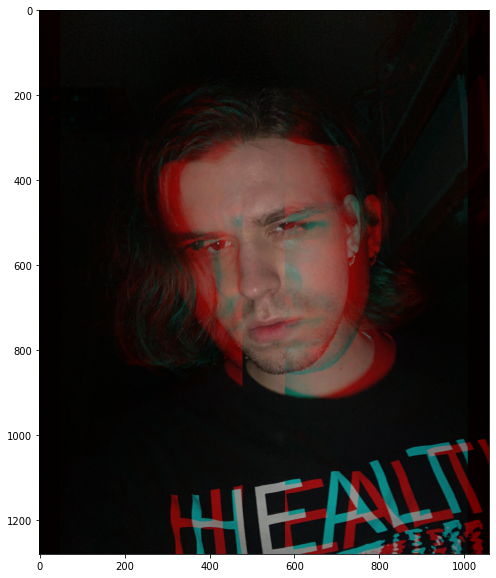

In [130]:
def layer(p,offset):
    x,y,_=p.shape
    res=np.zeros((x,y+int(2*offset),3),dtype="uint8")
    res[::,:y,1]=p[::,::,1]
    res[::,:y,2]=p[::,::,2]
    #res[::,offset:y+offset,1]=p[::,::,1]
    res[::,offset:y+offset,0]=p[::,::,0]
    #res[::,int(2*offset):,2]=p[::,::,2]
    return res


def layersplit(p,offset,offsetmid=0):
    x,y,_=p.shape
    res=np.zeros((x,y+int(2*offset),3),dtype="uint8")
    res[::,offset:y+offset,0]=p[::,::,0]
    res[::,:offsetmid+y//2,0]=p[::,:offsetmid+y//2,0]
    res[::,offsetmid+y//2+int(offset*2):,0]=p[::,offsetmid+y//2:,0]
    #res[::,:y,2]=p[::,::,2]
    res[::,offset:y+offset,1]=p[::,::,1]
    res[::,offset:y+offset,2]=p[::,::,2]
    #res[::,int(2*offset):,2]=p[::,::,2]
    return res

p = io.imread("in/ja4.jpg")
plt.figure(figsize=(10,10))
plt.imshow(layersplit(p,50))

In [17]:
@njit
def bayer4x4(p,N):
    bayermatrix = np.array([[0,8,2,10],
                            [12,4,14,6],
                            [3,11,1,9],
                            [15,7,13,5]])
    #bayermatrix=np.array([[0,2],[3,1]])
    res = p.copy()
    x,y,_=p.shape
    r = 255//N
    for i in prange(x):
        for j in range(y):
            noise = (bayermatrix[i%4,j%4]/16-0.5)*(1/N)
            res[i,j,0]= 255*np.floor((res[i,j,0]/255 + noise)*(N-1)+0.5)/(N-1)
            res[i,j,1]= 255*np.floor((res[i,j,1]/255 + noise)*(N-1)+0.5)/(N-1)
            res[i,j,2]= 255*np.floor((res[i,j,2]/255 + noise)*(N-1)+0.5)/(N-1)
    return res


@njit
def bayer4x4bw(p):
    bayermatrix = np.array([[0,8,2,10],
                            [12,4,14,6],
                            [3,11,1,9],
                            [15,7,13,5]])
    #bayermatrix=np.array([[0,2],[3,1]])
    res = p.copy()
    x,y,_=p.shape
    for i in prange(x):
        for j in range(y):
            noise = (bayermatrix[i%4,j%4]/16-0.5)*0.5
            res[i,j,0]= 255*np.floor((res[i,j,0]/255 + noise)+0.5)
            res[i,j,1]= 255*np.floor((res[i,j,1]/255 + noise)+0.5)
            res[i,j,2]= 255*np.floor((res[i,j,2]/255 + noise)+0.5)
    return res

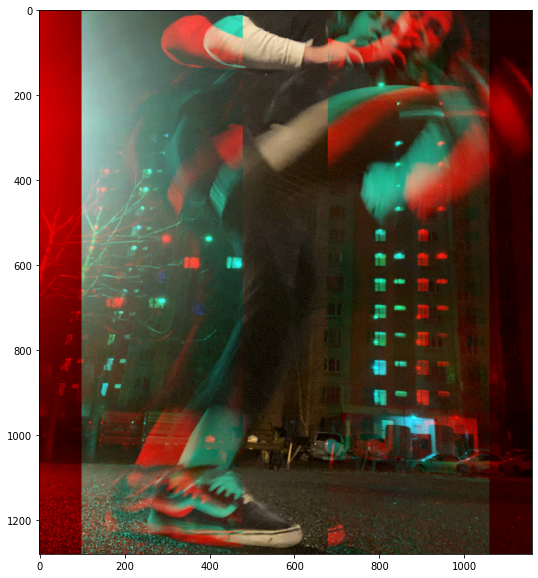

In [59]:
p = io.imread("in/ja.jpg")
plt.figure(figsize=(10,10))
plt.imshow(layersplit(bayer4x4(p,10),100))

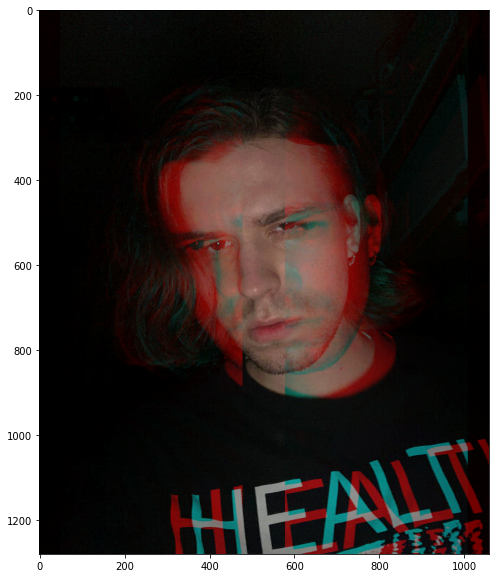

In [60]:
p = io.imread("in/ja4.jpg")
plt.figure(figsize=(10,10))
plt.imshow(layersplit(bayer4x4(p,10),50))

In [69]:
@njit
def hue(p):
    Hue = np.zeros(len(p))
    for i in range(len(p)):
        pixel=p[i]
        ind = np.argmax(pixel)
        indm = np.argmin(pixel)
        if pixel[ind]-pixel[indm]==0:
            Hue[i]=0
        elif ind==0:
            Hue[i]=(pixel[1]-pixel[2])/(pixel[ind]-pixel[indm])
        elif ind==1:
            Hue[i]=2.0 + (pixel[2]-pixel[0])/(pixel[ind]-pixel[indm])
        else:
            Hue[i]=4.0 + (pixel[0]-pixel[1])/(pixel[ind]-pixel[indm])
        if Hue[i]<0:
            Hue[i]+=360
    return Hue*60

@njit
def mask_hor(p,low=255/4,high=3*255/4):
    y, x, _ = p.shape
    res=np.zeros((y,x))
    for i in prange(y):
        for j in range(x):
            c = p[i,j,0]*0.299+0.587*p[i,j,1]+0.114*p[i,j,2]
            if c < low:
                continue
            if c > high:
                continue
            res[i,j]=1.0
    #plt.figure(figsize=(10,10))
    #plt.imshow(res,cmap="gray")
    to_sort=[]
    flag = True
    start = (0,0)
    l = 0
    for i in prange(y):
        start = (i,0)
        l = 0
        for j in range(x):
            if flag==True:
                if res[i,j]>0:
                    start=(i,j)
                    flag=False
            else:
                if res[i,j]>0:
                    l+=1
                    if j==x-1:
                        to_sort.append([start[0],start[1],l]) 
                else:
                    to_sort.append([start[0],start[1],l]) 
                    flag=True
                    l=0
                    start=(0,0)
    return np.array(to_sort)


@njit
def sort_hor(p, inc=True, low=255/4,high=3*255/4):
    to_sort=mask_hor(p,low,high)
    res=p.copy()
    for i in prange(len(to_sort)):
        #print(to_sort[i])
        chunk=to_sort[i]
        v = p[chunk[0],chunk[1]:chunk[1]+chunk[2],0]*0.299+p[chunk[0],chunk[1]:chunk[1]+chunk[2],1]*0.587+0.144*p[chunk[0],chunk[1]:chunk[1]+chunk[2],2]
        #print(v)
        order = np.argsort(v)
        line=p[chunk[0],chunk[1]:chunk[1]+chunk[2],::]
        #print(line[order])
        if inc:
            res[chunk[0],chunk[1]:chunk[1]+chunk[2],::]=line[order]
        else:
            res[chunk[0],chunk[1]:chunk[1]+chunk[2],::]=line[order[::-1]]
    return res


@njit
def huesort_hor(p, to_sort, incr=True):
    res=p.copy()
    for i in prange(len(to_sort)):
        #print(to_sort[i])
        chunk=to_sort[i]
        v = hue(p[chunk[0],chunk[1]:chunk[1]+chunk[2],:3])
        #print(v)
        order = np.argsort(v)
        line=p[chunk[0],chunk[1]:chunk[1]+chunk[2],:3]
        #print(line[order])
        if incr:
            res[chunk[0],chunk[1]:chunk[1]+chunk[2],:3]=line[order]
        else:
            res[chunk[0],chunk[1]:chunk[1]+chunk[2],:3]=line[order[::-1]]
    return res

959 1280


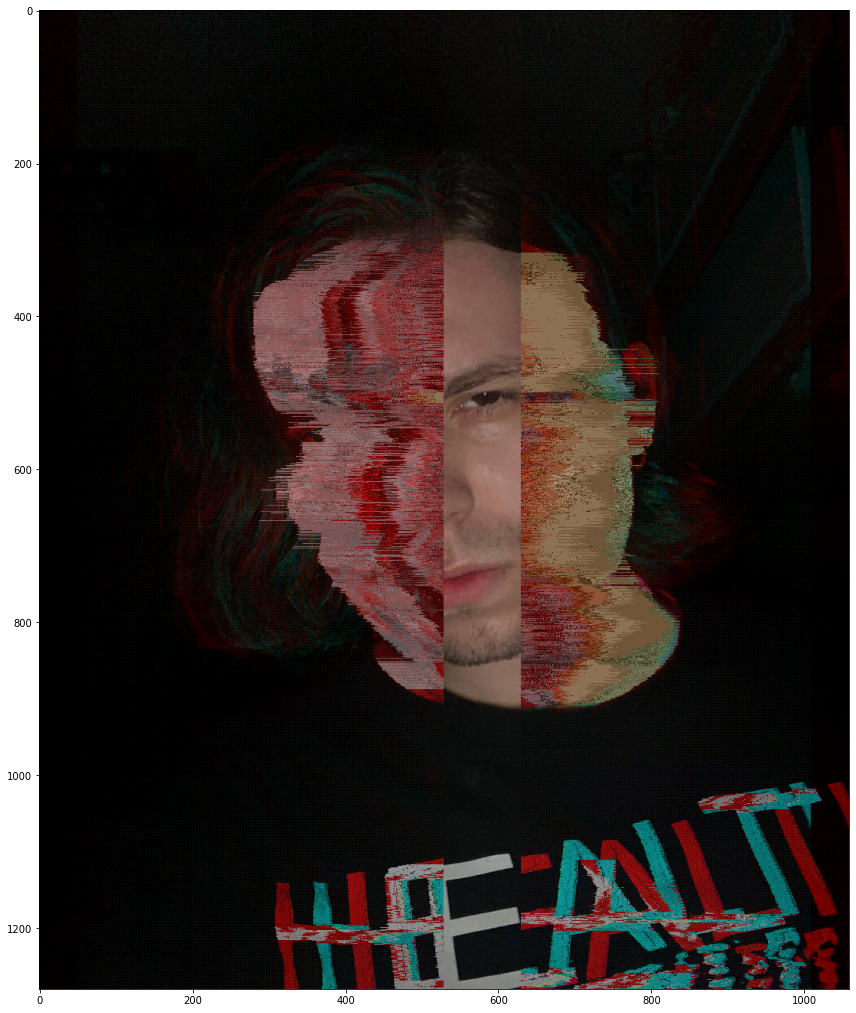

In [257]:
p = io.imread("in/ja4.jpg")
pp=io.imread("in/ja4.jpg")
y, x, _ = p.shape
print(x,y)
offset=50
offmid=50
plt.figure(figsize=(18,18))
p=huesort_hor(p,mask_hor(p,low=255/3,high=255),incr=False)
p=bayer4x4(p,10)
p=layersplit(p,offset,offsetmid=offmid)
p=huesort_hor(p,mask_hor(p,low=255/20,high=255),incr=True)
p[::,x//2+offmid:x//2+int(2*offset)+1+offmid,::]=pp[::,x//2+offmid-offset:x//2+int(offset)+1+offmid,::]
plt.imshow(p)
io.imsave("out/glitchjanice2.jpg",p)

In [ ]:
l=0.0
llow=255/4+255/4*np.cos(2*np.pi*l/500)-0.5
hhigh=3*255/4-255/4*np.cos(2*np.pi*l/500)+0.5
print(llow,hhigh,l)
mask_hor(io.imread("in/ja4.jpg"),low=llow,high=hhigh)

In [309]:
clips = []
p = io.imread("in/ja100.png")
slide2=io.imread("in/ja100.png")
y,x,_=p.shape
offset=50
offmid=50
l=0.0
for i in prange(250):
    slide=p.copy()
    llow=255/4+255/4*np.cos(np.pi*l/100)-0.5
    hhigh=3*255/4-255/4*np.cos(np.pi*l/100)+0.5
    mask = mask_hor(slide,low=llow,high=hhigh)
    slide=huesort_hor(slide,mask,incr=False)
    #slide=bayer4x4(slide,5)
    slide=layersplit(slide,offset,offsetmid=offmid)
    slide=huesort_hor(slide,mask_hor(slide,low=llow,high=hhigh),incr=True)
    slide[::,x//2+offmid:x//2+int(2*offset)+1+offmid,::]=slide2[::,x//2+offmid-offset:x//2+int(offset)+1+offmid,::]
    l+=1
    clips.append(mpe.ImageClip(slide,duration=1/24))
                 
vid = mpe.concatenate_videoclips(clips)
vid.write_videofile("out/ja69.mp4",fps=24,codec="libx264",audio=False)

Moviepy - Building video out/ja69.mp4.
Moviepy - Writing video out/ja69.mp4



Moviepy - Done !
Moviepy - video ready out/ja69.mp4


In [311]:
clips = []
p = io.imread("in/ja100.png")

slide2=io.imread("in/ja100.png")
y,x,_=p.shape
offset=50
offmid=50
l=0.0
for i in prange(250):
    slide=p.copy()
    llow=255/4+255/4*np.cos(2*np.pi*l/100)-0.5
    hhigh=3*255/4-255/4*np.cos(2*np.pi*l/100)+0.5
    mask = mask_hor(slide,low=llow,high=hhigh)
    slide=huesort_hor(slide,mask,incr=True)
    #slide=bayer4x4(slide,10)
    slide=layersplit(slide,offset,offsetmid=offmid)
    slide=huesort_hor(slide,mask_hor(slide,low=llow,high=hhigh),incr=True)
    #slide[::,x//2+offmid:x//2+int(2*offset)+1+offmid,::]=slide2[::,x//2+offmid-offset:x//2+int(offset)+1+offmid,::]
    l+=1
    clips.append(mpe.ImageClip(slide,duration=1/24))
                 
vid = mpe.concatenate_videoclips(clips)
vid.write_videofile("out/ja100.mp4",fps=24,codec="libx264",audio=False)

Moviepy - Building video out/ja100.mp4.
Moviepy - Writing video out/ja100.mp4



Moviepy - Done !
Moviepy - video ready out/ja100.mp4


In [307]:
p = io.imread("in/ja4.jpg")
io.imsave("in/ja100.png",p)